In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
#import seaborn as sns; sns.set()
style.use('fivethirtyeight')
#formatting $$
import matplotlib.ticker as mtick
%matplotlib inline

#utility functions
from cleanup_utilities import misc


In [2]:
!ls -lash *.csv

3890712 -rw-r--r--  1 ptreszczotko  staff   1.9G Sep 11 08:41 fpdsAllCSV.csv


# Read in 2016 federal spending data

In [23]:
#Bring in fpds 2016 data 
#this didnt work on a laptop with 16GBs of RAM
df = pd.read_csv('./fpdsAllCSV.csv',low_memory=True, dtype={'agencyID': str, 'PIID': str, 'modNumber': str, 'transactionNumber': int, 'obligatedAmount': float, 'baseAndExercisedOptionsValue': float, 'baseAndAllOptionsValue': float })



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,13,15,19,23,40,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
#how many columns were shifted during the import process?
badRows = df[df['status'] != 'F'] # should I drop them?
badRows.head(1)

,agencyID,PIID,modNumber,transactionNumber,IDVAgencyID,IDVPIID,IDVModificationNumber,signedDate,effectiveDate,currentCompletionDate,...,placeOfPerformanceCongressionalDistrict,extentCompeted,solicitationProcedures,typeOfSetAside,evaluatedPreference,numberOfOffersReceived,fedBizOpps,createdBy,lastModifiedBy,status
887489,3600,VA25515F0044,P00003,0,3600,V797P4237B,0,2015-10-09,2015-10-01,2016-09-30,...,A,NaN,NONE,NONE,NaN,0,N,2015-10-09 15:32:07,2017-03-01 10:25:40,NaN


# A bit of EDA first...

### Look at agencies that spend the most

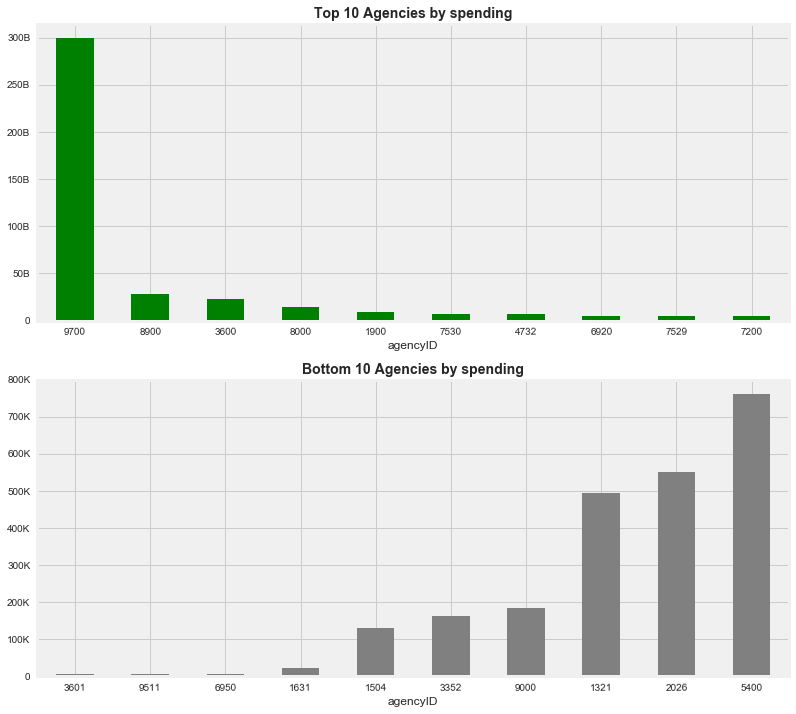

In [28]:
top_n = 10
mostSpent = df.groupby('agencyID')['obligatedAmount'].sum().sort_values(ascending=False)[:top_n]
leastSpent = df.groupby('agencyID')['obligatedAmount'].sum().sort_values(ascending=True)

#spending grater than 0
leastSpent = leastSpent[leastSpent > 0][:top_n]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

mostSpent.plot(kind='bar', x=mostSpent.index,y=mostSpent,
        align='center', width=.5, edgecolor='none', 
        color='green', ax=ax1, rot=1)

ax1.set_title('Top ' + str(top_n) + ' Agencies by spending',fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: misc.millify(x))) 

leastSpent.plot(kind='bar', x=mostSpent.index,y=mostSpent,
        align='center', width=.5, edgecolor='none', 
        color='gray', ax=ax2, rot=1)

ax2.set_title('Bottom ' + str(top_n) + ' Agencies by spending',fontsize=14, fontweight='bold')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: misc.millify(x))) 


### Convert AgencyIDs to their corresponding names

In [29]:
# Get another data set that maps agencyIds to their names
## Need to import FIPS-95

#import agecncyIds from FIPS 95-2
agencyNames = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9NFxZhw7nn8RkJ7Y6UIjSbTObYlcNgwtlA9_dnaSFb2wmbEijgyEVCleQl6rwxxq61UhzgLm2Azmq/pub?output=csv', index_col='agencyID')
departmentName = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9NFxZhw7nn8RkJ7Y6UIjSbTObYlcNgwtlA9_dnaSFb2wmbEijgyEVCleQl6rwxxq61UhzgLm2Azmq/pub?output=csv', index_col='departmentID')

#find agencies that are not in the lookup table and add them manually
missingAgencyIDs = df[~df['agencyID'].isin(agencyNames.index)]['agencyID'].unique()

#proceed when all agencies are filled in
missingAgencyIDs

array([], dtype=object)

In [38]:
# add agency names to mostSpent data frame

agencyNames
pd.merge(agencyNames,mostSpent, left_index = True, right_index = True)
#pd.merge(mostSpent,agencyNames, how='inner', on=['agencyID'])

mostSpent

ValueError: can not merge DataFrame with instance of type <class 'pandas.core.series.Series'>

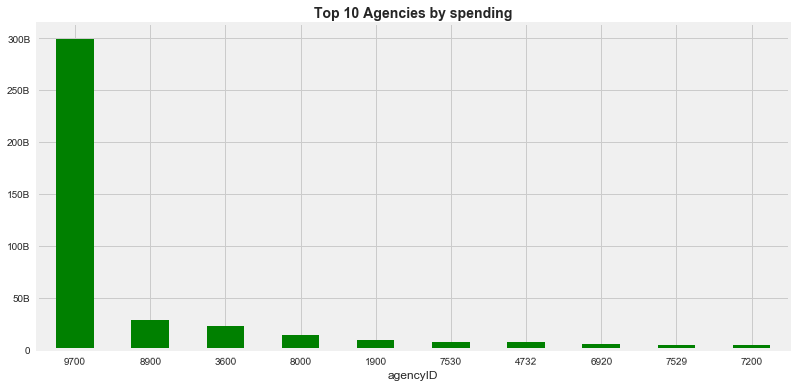

In [32]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

mostSpent.plot(kind='bar', x=mostSpent.index,y=mostSpent,
        align='center', width=.5, edgecolor='none', 
        color='green', ax=ax1, rot=1)

ax1.set_title('Top ' + str(top_n) + ' Agencies by spending',fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: misc.millify(x))) 

ax1.legend()